In [1]:
import numpy as np
import scipy
import copy
import matplotlib.pyplot as plt
import statsmodels as sm
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.gaussian_process.kernels import RBF
import scipy.stats as stats
import math
from mpl_toolkits import mplot3d
from cosde.cosde import MultiCOSDE
from cosde.osde import MultiOSDE

### test univariate normal distribution

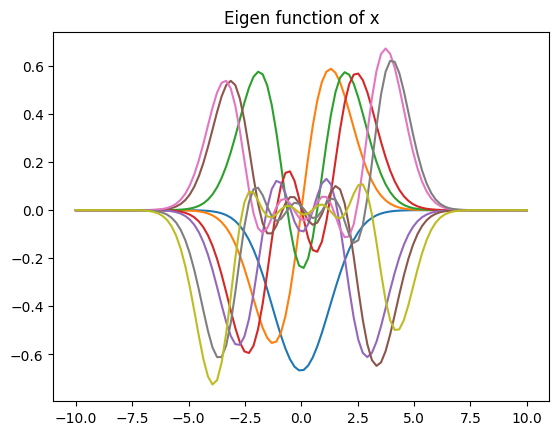

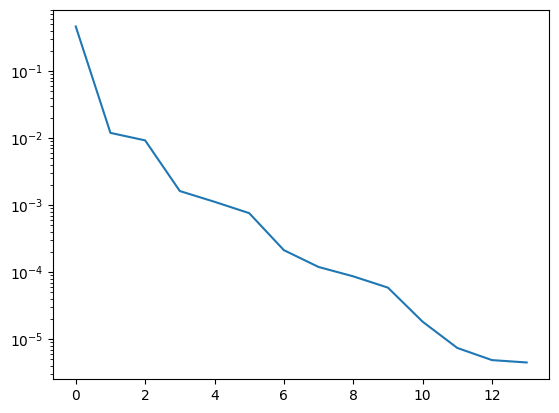

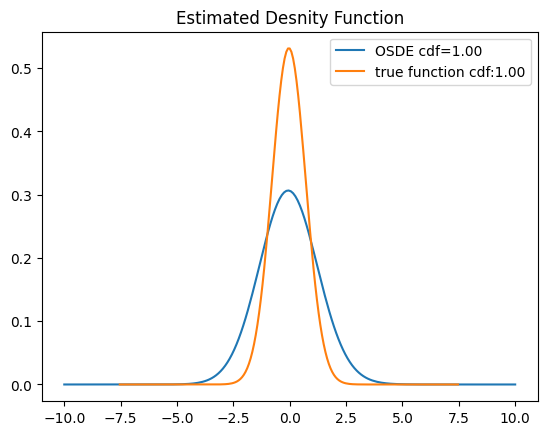

flip functions:  0


In [2]:
##test MultiCOSDE

#test 2 variables
kernelx = RBF(1.)
kernely = RBF(1.)

f_xy = MultiCOSDE([kernelx], [kernely])
mu1 = 0
mu2 = 5
sigma11 = 1
sigma12 = 0.5
sigma22 = 1
data = np.random.multivariate_normal(np.array([mu1,mu2]), np.array([[sigma11, sigma12], [sigma12, sigma22]]), size=2000)
data_x = data[:,0].reshape((-1,1))
data_y = data[:,1].reshape((-1,1))

f_xy.fit([data_x], [data_y], 1, max_r=50)



for i in range(1,10):
  eigen = f_xy.get_singular_function(1,i)
  new_x = np.linspace(-10,10,100)
  f_x = np.zeros(new_x.shape)
  for j, x in enumerate(new_x):
    f_x[j] = eigen.eval(x.reshape((1,1)))

  plt.plot(new_x, f_x)

plt.title('Eigen function of x')
plt.show()


#test get_singular_value()
sample_y = np.random.uniform(2,8, size=(1,1))

keep_idx, sigv = f_xy.get_singular_values([sample_y], 1e-5)

plt.plot(np.abs(sigv))
plt.yscale('log')
plt.show()

#test get_pdf()
new_x = np.linspace(-10,10,200)

cdf = 0
predict_x = np.zeros(new_x.shape)
d0 = new_x[0]
for i, d in enumerate(new_x):
  predict_x[i] = f_xy.get_pdf([d.reshape((1,1))], [sample_y], 1e-3)
  cdf += predict_x[i]*(d-d0)
  d0 = d
plt.title('Estimated Desnity Function')
plt.plot(new_x,predict_x, label='OSDE cdf=%.2f'%cdf)   

mu_xy = mu1 + sigma12/sigma22 * (sample_y.squeeze() - mu2)
sigma_xy = sigma11 - sigma12**2/sigma22
#mu = 0
#variance = 1
##sigma = math.sqrt(variance)
x = np.linspace(mu_xy - 10*sigma_xy, mu_xy + 10*sigma_xy, 200)
cdf = np.sum(stats.norm.pdf(x, mu_xy, sigma_xy))*(20*sigma_xy/200)
plt.plot(x, stats.norm.pdf(x, mu_xy, sigma_xy), label='true function cdf:%.2f'%cdf)

plt.legend()
plt.show()



#compare with density ratio estimator

fr_xy = MultiOSDE([kernelx, kernely])
fr_xy.fit([data_x, data_y])

fr_y = MultiOSDE([kernely])
fr_y.fit([data_y])




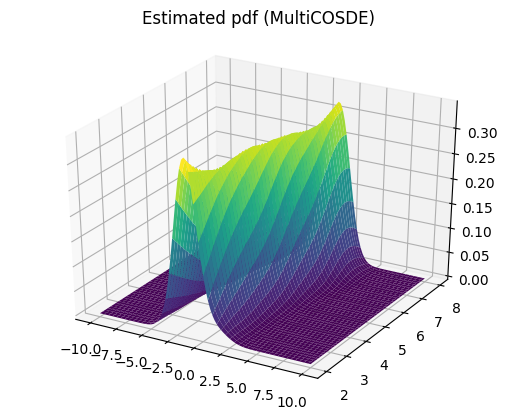

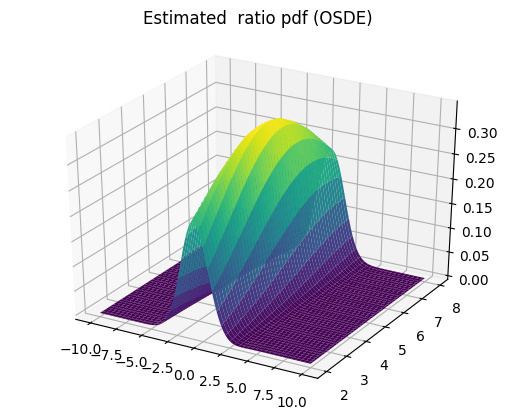

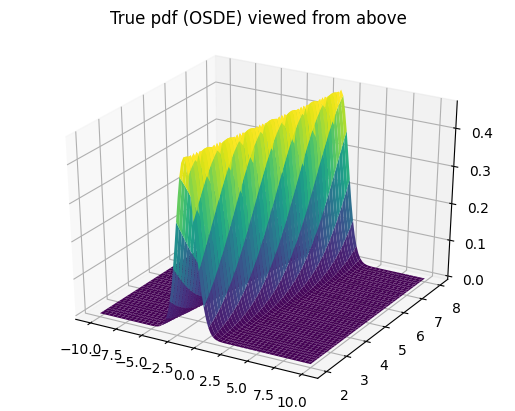

In [3]:
# test get_pdf over the grid of y


#test MultiCOSDE
new_x = np.linspace(-10,10,100)
new_y = np.linspace(2,8,50)

grid = np.meshgrid(new_x,new_y)
cosde_pdf = np.zeros((new_x.size, new_y.size))
i=0
area = 0
cmf = 0

for j, y in enumerate(new_y):
  for i, d in enumerate(new_x):
    cosde_pdf[i, j] = f_xy.get_pdf([d.reshape((1,1))], [y.reshape(1,1)], 1e-3)

  


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], cosde_pdf.T,
                cmap='viridis',linewidth=0)


ax.title.set_text('Estimated pdf (MultiCOSDE)')


#density ratio estimator (MultiOSDE)


ratio_pdf = np.zeros((new_x.size, new_y.size))
for j, y in enumerate(new_y):
  for i, x in enumerate(new_x):
    sample = [x.reshape(1,1), y.reshape(1,1)]
    ratio_pdf[i,j] = fr_xy.get_pdf(sample)/(fr_y.get_pdf([y.reshape(1,1)]))


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], ratio_pdf.T,
                cmap='viridis',linewidth=0)


ax.title.set_text('Estimated  ratio pdf (OSDE)')





#true pdf


grid = np.meshgrid(new_x,new_y)
true_pdf = np.zeros((new_x.size, new_y.size))
for i, y in enumerate(new_y):
  mu_x = mu1 + sigma12/sigma22*(y-mu2)
  var = sigma11 - sigma12**2/sigma22
  rv = stats.multivariate_normal([mu_x], [var])
  true_pdf[:,i] = rv.pdf(new_x)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( grid[0],  grid[1], true_pdf.T,cmap='viridis',linewidth=0)

ax.title.set_text('True pdf (OSDE) viewed from above')

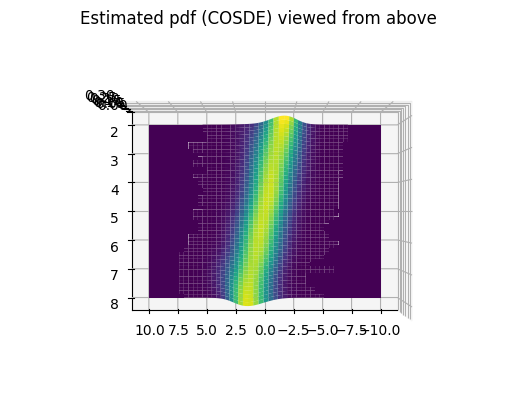

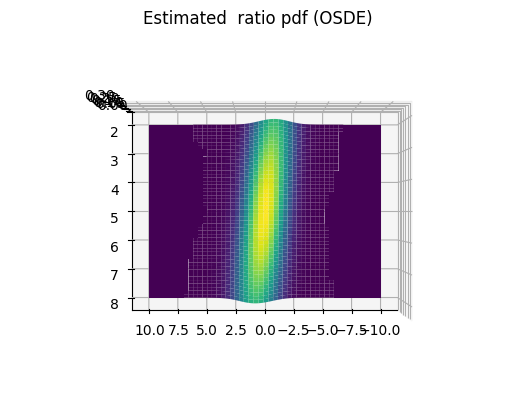

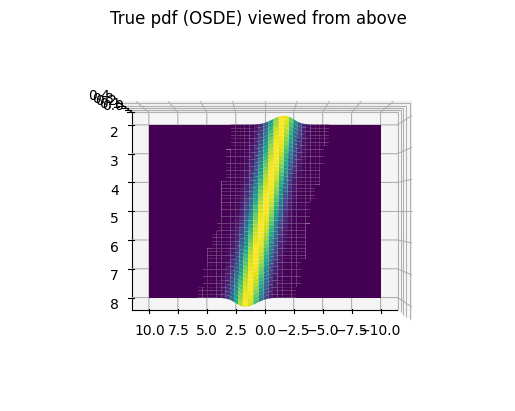

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], cosde_pdf.T,
                cmap='viridis',linewidth=0, label='area:%.2')
ax.view_init(90,90)

ax.title.set_text('Estimated pdf (COSDE) viewed from above')


#density ratio estimator (MultiOSDE)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], ratio_pdf.T,
                cmap='viridis',linewidth=0, label='area:%.2')
ax.view_init(90,90)


ax.title.set_text('Estimated  ratio pdf (OSDE)')




new_x = np.linspace(-10,10,100)
new_y = np.linspace(2,8,50)

grid = np.meshgrid(new_x,new_y)
true_pdf = np.zeros((new_x.size, new_y.size))
for i, y in enumerate(new_y):
  mu_x = mu1 + sigma12/sigma22*(y-mu2)
  var = sigma11 - sigma12**2/sigma22
  rv = stats.multivariate_normal([mu_x], [var])
  true_pdf[:,i] = rv.pdf(new_x)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( grid[0],  grid[1], true_pdf.T,cmap='viridis',linewidth=0)
ax.view_init(90,90)
ax.title.set_text('True pdf (OSDE) viewed from above')

##### Test 2: univariate Gaussian mixture

Assume that $X,Y$ are conditional indpendent given $U$, a Bernoulli random variable ($p=0.3$).
$$
(X,Y)\mid U=0\sim\mathcal{N}({\bf 0}, I)
$$
and 
$$
(X,Y)\mid U=1\sim\mathcal{N}({\bf 5}, I)
$$
So the conditional density function is
$$
p(x\mid y)=\frac{0.3\mathcal{N}({\bf 0}, I)+0.7\mathcal{N}({\bf 5}, I)}{0.3\mathcal{N}(0,1)+0.7\mathcal{N}(5,1)}
$$

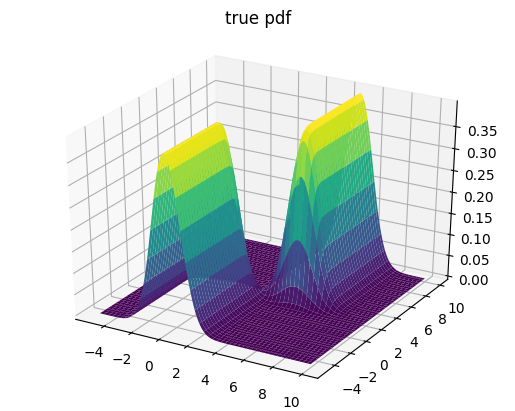

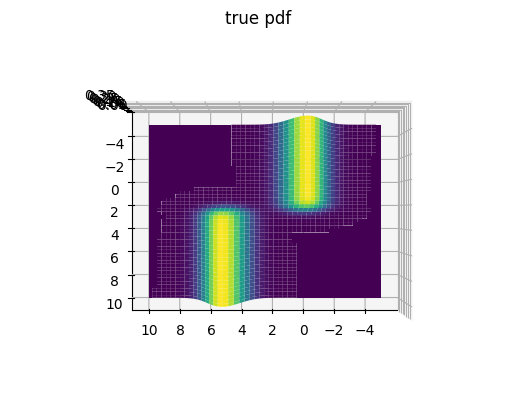

In [5]:
#Create grid and multivariate normal
new_x = np.linspace(-5,10,200)
new_y = np.linspace(-5,10,200)

grid = np.meshgrid(new_x,new_y)
data_x = grid[0].flatten()
data_y = grid[1].flatten()

pos = np.empty(grid[0].shape + (2,))
pos[:, :, 0] =  grid[0]
pos[:, :, 1] =  grid[1]
rv1_xy = stats.multivariate_normal([0, 0], [[1, 0], [0, 1]])
rv2_xy = stats.multivariate_normal([5, 5], [[1, 0], [0, 1]])

rv1_y = stats.multivariate_normal([0], [1])
rv2_y = stats.multivariate_normal([5], [1])

p_y = (0.3*rv1_y.pdf(pos[:,:,1][:,:,np.newaxis])+0.7*rv2_y.pdf(pos[:,:,1][:,:,np.newaxis]))
p_xy = 0.3*rv1_xy.pdf(pos)+0.7*rv2_xy.pdf(pos)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( grid[0],  grid[1],p_xy/p_y ,cmap='viridis',linewidth=0)



ax.title.set_text('true pdf')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( grid[0],  grid[1],p_xy/p_y ,cmap='viridis',linewidth=0)

ax.view_init(90,90)

ax.title.set_text('true pdf')

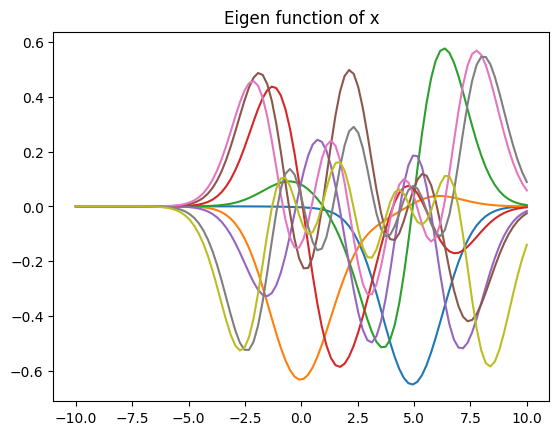

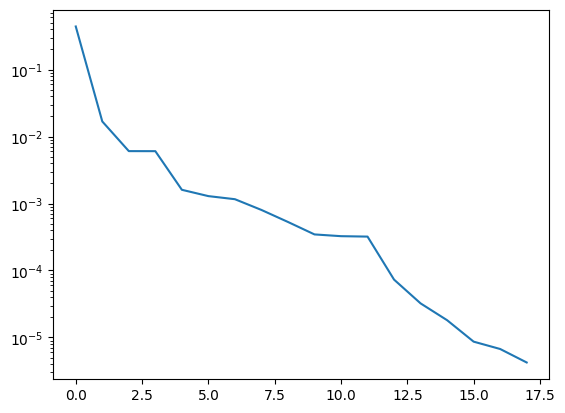

flip functions:  0
flip functions:  1


In [6]:
def gaussian_mixture(N):
  #[0.1,0.2,0.7]
  U = np.random.uniform(0,1,N)
  X = np.random.normal(0,1, size=(N,2))
  #idx_0 = np.where(U<0.4)
  idx_1 = np.where(U>=0.3)
  X[idx_1[0],:] += 5 #shift in mean
  return X

data = gaussian_mixture(1000)
data_x = data[:,0].reshape(-1,1)
data_y = data[:,1].reshape(-1,1)

#test 2 variables
kernelx = RBF(1.1)
kernely = RBF(1.1)

f_xy = MultiCOSDE([kernelx], [kernely])


f_xy.fit([data_x], [data_y], 1, max_r=20)



for i in range(1,10):
  eigen = f_xy.get_singular_function(1,i)
  new_x = np.linspace(-10,10,100)
  f_x = np.zeros(new_x.shape)
  for j, x in enumerate(new_x):
    f_x[j] = eigen.eval(x.reshape((1,1)))

  plt.plot(new_x, f_x)

plt.title('Eigen function of x')
plt.show()


#test get_singular_value()
sample_y = np.random.uniform(2,8, size=(1,1))

keep_idx, sigv = f_xy.get_singular_values([sample_y], 1e-5)

plt.plot(np.abs(sigv))
plt.yscale('log')
plt.show()



#compare with density ratio estimator

fr_xy = MultiOSDE([kernelx, kernely])
fr_xy.fit([data_x, data_y])

fr_y = MultiOSDE([kernely])
fr_y.fit([data_y])

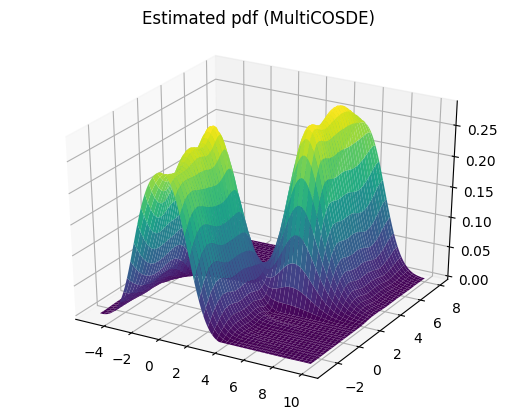

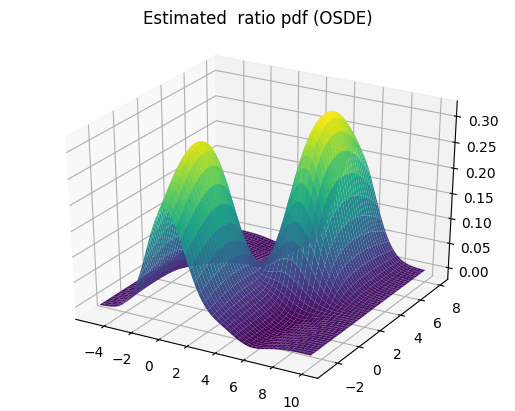

In [7]:
# test get_pdf over the grid of y


#test MultiCOSDE
new_x = np.linspace(-5,10,200)
new_y = np.linspace(-3,8,200)

grid = np.meshgrid(new_x,new_y)
cosde_pdf = np.zeros((new_x.size, new_y.size))
i=0
area = 0
cmf = 0

for j, y in enumerate(new_y):
  for i, d in enumerate(new_x):
    cosde_pdf[i, j] = f_xy.get_pdf([d.reshape((1,1))], [y.reshape(1,1)], 1e-3)

  


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], cosde_pdf.T,
                cmap='viridis',linewidth=0)


ax.title.set_text('Estimated pdf (MultiCOSDE)')


#density ratio estimator (MultiOSDE)


ratio_pdf = np.zeros((new_x.size, new_y.size))
for j, y in enumerate(new_y):
  for i, x in enumerate(new_x):
    sample = [x.reshape(1,1), y.reshape(1,1)]
    ratio_pdf[i,j] = fr_xy.get_pdf(sample)/(fr_y.get_pdf([y.reshape(1,1)]))


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], ratio_pdf.T,
                cmap='viridis',linewidth=0)


ax.title.set_text('Estimated  ratio pdf (OSDE)')





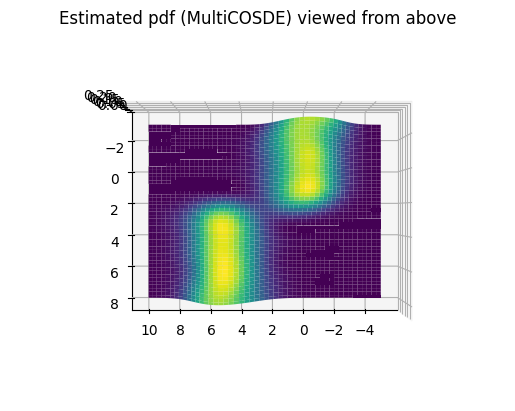

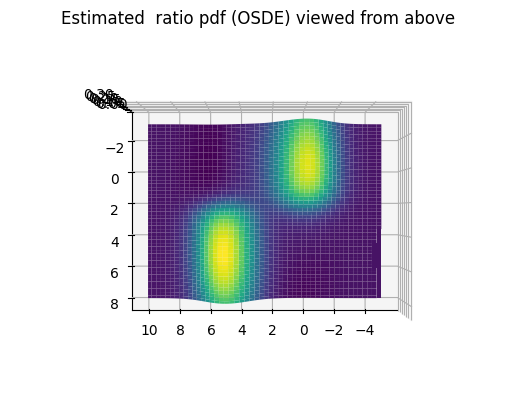

In [8]:
# test get_pdf over the grid of y


#test MultiCOSDE




fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], cosde_pdf.T,
                cmap='viridis',linewidth=0)

ax.view_init(90,90)
ax.title.set_text('Estimated pdf (MultiCOSDE) viewed from above')


#density ratio estimator (MultiOSDE)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(grid[0], grid[1], ratio_pdf.T,
                cmap='viridis',linewidth=0)

ax.view_init(90,90)
ax.title.set_text('Estimated  ratio pdf (OSDE) viewed from above')



